In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
from concurrent import futures
import threading
from sklearn.model_selection import train_test_split
from collections import Counter

In [3]:
#Load Dataset
# set cell_images folder path for dataset
root ="/content/gdrive/My Drive/Malaria_dataset/cell_images"

# read dataset
base_dir = os.path.join('/content/gdrive/My Drive/Malaria_dataset/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13794)

In [4]:
#Check top 5 rows of data
np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
1,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
2,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
3,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
4,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria


In [5]:
# Partition dataset into training(60),testing(30),validation(10) 
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17370,) (1931,) (8272,)
Train: Counter({'healthy': 8766, 'malaria': 8604}) 
Val: Counter({'malaria': 979, 'healthy': 952}) 
Test: Counter({'malaria': 4196, 'healthy': 4076})


In [6]:
IMG_DIMS = (125,125)
def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.bilateralFilter(img, 15, 75, 75)
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_1: working on img num: 5000
ThreadPoolExecutor-0_8: working on img num: 10000
ThreadPoolExecutor-0_0: working on img num: 15000
ThreadPoolExecutor-0_8: working on img num: 17369

Loading Validation Images:ThreadPoolExecutor-0_0: working on img num: 0

ThreadPoolExecutor-0_9: working on img num: 1930

Loading Test Images:
ThreadPoolExecutor-0_12: working on img num: 0
ThreadPoolExecutor-0_5: working on img num: 5000
ThreadPoolExecutor-0_18: working on img num: 8271


((17370, 125, 125, 3), (1931, 125, 125, 3), (8272, 125, 125, 3))

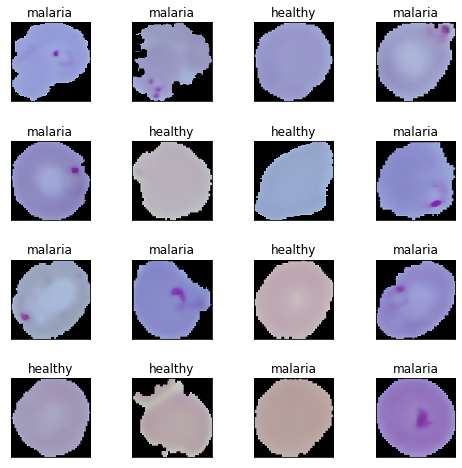

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [8]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 35
INPUT_SHAPE = (125, 125, 3)

# change version of tensorflow
%tensorflow_version 2.x

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
print(train_labels[:6], train_labels_enc[:6])

TensorFlow 2.x selected.
['healthy' 'healthy' 'healthy' 'healthy' 'healthy' 'healthy'] [0 0 0 0 0 0]


Labels: ['healthy', 'healthy', 'healthy', 'healthy', 'healthy']


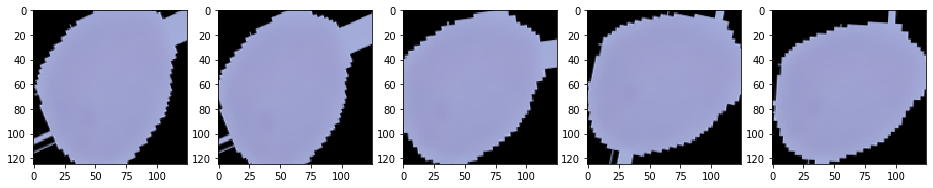

In [9]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

#Applying Data augmentation to images
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# check augmented images
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

**Resnet-50 Model**

In [36]:
#Load pretrained model
resnet = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, weights=None, 
                                        input_shape=INPUT_SHAPE)

for layer in resnet.layers:
    layer.trainable = True
    
base_resnet = resnet
base_out = base_resnet.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(2048, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(2048, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_resnet.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 131, 131, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 63, 63, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 65, 65, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [37]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 196
Total trainable layers: 196


In [38]:
#train model
import datetime
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/35
271/271 [==============================] - 70s 259ms/step - loss: 0.6980 - accuracy: 0.6646 - val_loss: 3.1207 - val_accuracy: 0.5240
Epoch 2/35
271/271 [==============================] - 59s 218ms/step - loss: 0.2130 - accuracy: 0.9326 - val_loss: 0.2849 - val_accuracy: 0.9344
Epoch 3/35
271/271 [==============================] - 58s 215ms/step - loss: 0.1773 - accuracy: 0.9512 - val_loss: 0.2732 - val_accuracy: 0.9156
Epoch 4/35
271/271 [==============================] - 59s 217ms/step - loss: 0.1614 - accuracy: 0.9527 - val_loss: 0.3173 - val_accuracy: 0.9422
Epoch 5/35
271/271 [==============================] - 59s 217ms/step - loss: 0.1607 - accuracy: 0.9564 - val_loss: 0.2086 - val_accuracy: 0.9526
Epoch 6/35
271/271 [==============================] - 58s 215ms/step - loss: 0.1646 - accuracy: 0.9571 - val_loss: 0.3085 - val_accuracy: 0.9469
Epoch 7/35
271/271 [=================

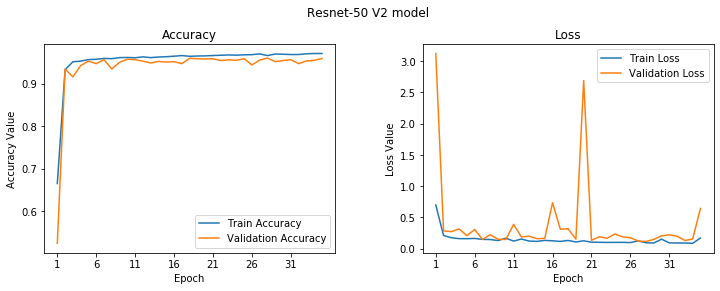

In [39]:
#Plot accuracy and loss of training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Resnet-50 V2 model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Resnet50_V2.h5')

**Resnet-101** Model


In [41]:
#Load pretrained model
resnet = tf.keras.applications.resnet_v2.ResNet101V2(include_top=False, weights=None, 
                                        input_shape=INPUT_SHAPE)

for layer in resnet.layers:
    layer.trainable = True
    
base_resnet = resnet
base_out = base_resnet.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(2048, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(2048, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_resnet.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 131, 131, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 63, 63, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 65, 65, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [42]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 383
Total trainable layers: 383


In [43]:
#train model
import datetime
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/35
271/271 [==============================] - 82s 304ms/step - loss: 0.8659 - accuracy: 0.5915 - val_loss: 3.6563 - val_accuracy: 0.4932
Epoch 2/35
271/271 [==============================] - 66s 244ms/step - loss: 0.3929 - accuracy: 0.8368 - val_loss: 0.8322 - val_accuracy: 0.6917
Epoch 3/35
271/271 [==============================] - 66s 244ms/step - loss: 0.1980 - accuracy: 0.9422 - val_loss: 0.4970 - val_accuracy: 0.8667
Epoch 4/35
271/271 [==============================] - 66s 244ms/step - loss: 0.1602 - accuracy: 0.9508 - val_loss: 0.2855 - val_accuracy: 0.9141
Epoch 5/35
271/271 [==============================] - 66s 244ms/step - loss: 0.2003 - accuracy: 0.9544 - val_loss: 0.2282 - val_accuracy: 0.9224
Epoch 6/35
271/271 [==============================] - 66s 244ms/step - loss: 0.1351 - accuracy: 0.9556 - val_loss: 19.6292 - val_accuracy: 0.9208
Epoch 7/35
271/271 [================

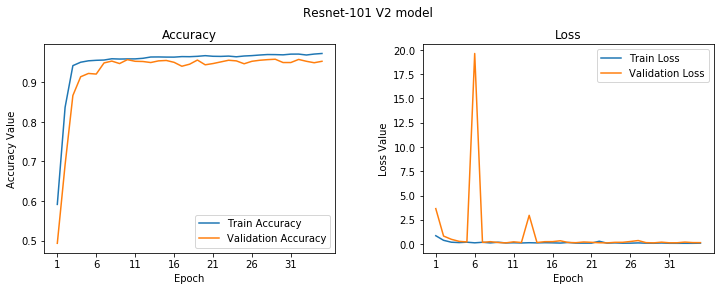

In [44]:
#Plot accuracy and loss of training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Resnet-101 V2 model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Resnet101_v2.h5')

**Resnet-152** Model

In [46]:
#Load pretrained model
resnet = tf.keras.applications.resnet_v2.ResNet152V2(include_top=False, weights=None, 
                                        input_shape=INPUT_SHAPE)

for layer in resnet.layers:
    layer.trainable = True
    
base_resnet = resnet
base_out = base_resnet.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(2048, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(2048, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_resnet.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 131, 131, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 63, 63, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 65, 65, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [47]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))

Total Layers: 570
Total trainable layers: 570


In [0]:
#train model
import datetime
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/35
271/271 [==============================] - 122s 451ms/step - loss: 0.8483 - accuracy: 0.5544 - val_loss: 2.4567 - val_accuracy: 0.4932
Epoch 2/35
271/271 [==============================] - 94s 347ms/step - loss: 0.5032 - accuracy: 0.7562 - val_loss: 172.8886 - val_accuracy: 0.5068
Epoch 3/35
271/271 [==============================] - 94s 347ms/step - loss: 0.2065 - accuracy: 0.9337 - val_loss: 17.9663 - val_accuracy: 0.5177
Epoch 4/35
271/271 [==============================] - 94s 348ms/step - loss: 0.1900 - accuracy: 0.9495 - val_loss: 0.2124 - val_accuracy: 0.9547
Epoch 5/35
271/271 [==============================] - 94s 347ms/step - loss: 0.1534 - accuracy: 0.9502 - val_loss: 14.4460 - val_accuracy: 0.9417
Epoch 6/35
271/271 [==============================] - 94s 347ms/step - loss: 0.5151 - accuracy: 0.9523 - val_loss: 0.2490 - val_accuracy: 0.9365
Epoch 7/35
271/271 [============

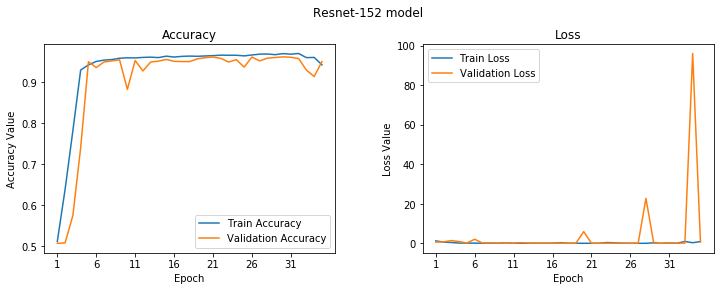

In [30]:
#Plot accuracy and loss of training and validation data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Resnet-152 V2 model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Resnet152_v2.h5')

**Test models** on testing data

In [26]:
#scale test data
#test_data = to_categorical(test_data)
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8272, 125, 125, 3), (8272,))

In [0]:
# Load Saved Deep Learning Models
resnet50 = tf.keras.models.load_model('/content/Resnet50.h5')
resnet101 = tf.keras.models.load_model('/content/Resnet101.h5')
resnet152 = tf.keras.models.load_model('/content/Resnet152.h5')

# Make Predictions on Test Data
resnet50_preds = resnet50.predict(test_imgs_scaled, batch_size=512)
resnet101_preds = resnet101.predict(test_imgs_scaled, batch_size=512)
resnet152_preds = resnet152.predict(test_imgs_scaled, batch_size=512)

resnet50_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in resnet50_preds.ravel()])
resnet101_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in resnet101_preds.ravel()])
resnet152_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in resnet152_preds.ravel()])

In [0]:
#Upload model evaluation file named as model_evaluation_utils
from google.colab import files 
uploaded = files.upload()

In [34]:
import model_evaluation_utils as meu
import pandas as pd

resnet50_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=resnet50_pred_labels)
resnet101_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=resnet101_pred_labels)
resnet152_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=resnet152_pred_labels)

pd.DataFrame([resnet50_metrics, resnet101_metrics, resnet152_metrics ], 
             index=['Resnet-50 ' , 'Resnet-101 ', 'Resnet-152 '])

,Accuracy,Precision,Recall,Sensitivity,specificity,F1 Score
Resnet-50,96.1315,96.2118,96.1315,94.2299,98.1371,96.1310
Resnet-101,95.5754,95.6963,95.5754,93.2804,98.0432,95.5742
Resnet-152,95.4787,95.6087,95.4787,93.1067,98.0392,95.4773
